### Initial Configurations and Imports

In [1]:
import json
import logging

import numpy as np
from scipy.stats import wilcoxon

from pathlib import Path
from tqdm import tqdm
 

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("output_paths", {}).get("stats")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading main dataframe

In [4]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413
1.58747780630413


 Selecting Samples with sample size >= 1024

In [3]:
meta_donor_df_filtered = meta_donor_df.copy()

number_of_samples_per_br_ge = get_number_of_samples_per_br_ge(meta_donor_df_filtered)

range_with_powers_of_two = [2**i for i in range(3, 11)]

count_per_threshold= get_br_ge_count_above_sample_size(meta_donor_df_filtered, range = range_with_powers_of_two)

meta_donor_df_filtered = mask_samples_threshold(meta_donor_df_filtered, threshold=1024)

meta_donor_df_filtered = meta_donor_df_filtered.reset_index(drop=True)
write_df_to_csv(meta_donor_df_filtered, PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered.csv"))

logger.info(f"DF Length after filtering matches number of samples expected: {count_per_threshold[len(count_per_threshold)-1]==len(meta_donor_df_filtered)}")
logger.info(count_per_threshold[len(count_per_threshold)-1])


DF Length after filtering matches number of samples expected: True
278


### Calculating Gene Mean Expression Values (H0)

In [4]:
geneid_H0 = calculate_gene_mean_expression_values(meta_donor_df)
logger.info(f"Number of Total Sample Count == {geneid_H0['total_sample_count'].sum() == get_total_number_of_samples(meta_donor_df)}")

Number of Total Sample Count == True


Calculating STD for Effect Sizes

In [5]:
df_std = meta_donor_df.copy()

std_per_gene = calculate_std_gene_id_optimized(df_std)

geneid_H0["std"] = std_per_gene["std"]
write_df_to_csv(geneid_H0, OUTPUT_DATA / Path("gene_stats.csv"))
geneid_H0.head(3)

,gene_id,total_expression,total_sample_count,weighted_mean,std
0,2,16227.834876,3936,4.122926,2.693218
1,3,66283.660534,7872,8.420180,2.464688
2,6,41203.873837,13776,2.990990,2.067025


### Calculating P-values, Effect Size, T-statistic and Power for Different Sample Sizes

In [6]:
stats_df = pd.DataFrame(meta_donor_df_filtered).drop(columns=["gene_expression_values", "sample_count"])
for index, br_ge in tqdm(meta_donor_df_filtered.iterrows(), total=len(meta_donor_df_filtered), desc="Processing Samples"):
    effect_sizes, p_values, powers, t_obs_stats =[], [], [], []
    for sample_size in range_with_powers_of_two:
        # Getting Sample Values
        sample = br_ge["gene_expression_values"]
        
        if sample_size > len(sample):
            logger.error(f"Reproducing Error, sample size available: {len(sample)} < sample_size chosen: {sample_size}")
            raise Exception
        else:
            sample = sample[:sample_size]
        
        if len(sample) == 1:
            raise ValueError
        
        # Getting Brain region and Gene ID
        gene_id = br_ge["gene_id"]
        brain_region = br_ge["brain_region"]
        
        # Calculating Sample Stats
        sample_mean = np.mean(sample)
        sample_std = np.std(sample)
        
        
        # Getting Control Group stats for that gene
        control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]
        control_group_std = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "std"].iloc[0]
        control_group_size = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "total_sample_count"].iloc[0]


        # (1) Calculating Effect Size.
        effect_size = calculate_cohen_d(sample_mean=sample_mean, control_group_mean=control_group_mean,
                        sample_std=sample_std, control_group_std=control_group_std,
                        sample_length=sample_size, control_group_length=control_group_size)

        # (2) Calculating Power
        power = calculate_test_power(effect_size, sample_mean, control_group_mean, sample_std, sample_size)
        
        # (3) Wilcoxon to Calculate the p_value and the t-statistic 
        t_static, p_value  = wilcoxon(np.array(sample) - control_group_mean, alternative='greater')

        stats_df.loc[index, f"effect_size_{sample_size}"] = effect_size
        stats_df.loc[index, f"p-value_{sample_size}"] = p_value
        stats_df.loc[index, f"power_{sample_size}"] = power
        stats_df.loc[index, f"t_stat_{sample_size}"] = t_static

    
    
write_df_to_csv(stats_df, OUTPUT_DATA / Path(f"df_stats.csv"))



Processing Samples: 100%|██████████| 278/278 [00:04<00:00, 65.26it/s]


In [7]:
stats_df.head(3)

,brain_region,gene_id,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,t_stat_16,...,power_256,t_stat_256,effect_size_512,p-value_512,power_512,t_stat_512,effect_size_1024,p-value_1024,power_1024,t_stat_1024
0,4012,2541,0.723958,0.039062,0.579479,31.0,0.170152,0.231873,0.159962,83.0,...,0.988638,21436.0,0.179155,8.732317e-07,0.991882,81676.0,0.285270,1.100408e-22,1.000000,354526.0
1,4013,1259,0.576161,0.125000,0.431013,27.0,-0.327191,0.798126,0.001882,52.0,...,0.991683,21943.0,0.152272,4.490161e-06,0.963761,80536.0,0.088223,1.216660e-05,0.880289,302356.0
2,4013,2541,0.716566,0.054688,0.572157,30.0,0.205089,0.247711,0.194567,82.0,...,0.999900,22748.0,0.324791,3.459548e-14,1.000000,90748.0,0.264883,9.052327e-20,1.000000,347825.0


Filter out Brain Regions with few Occurrences to plot

In [8]:
# Group by brain_region and count occurrences
group_counts = stats_df["brain_region"].value_counts()

# Filter out brain regions that have less than 8 occurrences
valid_regions = group_counts[group_counts >= 8].index

# Filter original DataFrame
filtered_df = stats_df[stats_df["brain_region"].isin(valid_regions)].drop(columns=['gene_id'])
filtered_df = filtered_df[filtered_df['brain_region'] != 4288]
filtered_df = filtered_df.groupby("brain_region")

# Calculating Mean and Variances
filtered_df_mean = filtered_df.mean()
filtered_df_var = filtered_df.var()


### Effect Size VS Sample Size Plots

In [5]:
# Define the range of sample sizes as powers of 2
range_with_powers_of_two = [2**i for i in range(3, 11)]  # 2^3=8 to 2^10=1024

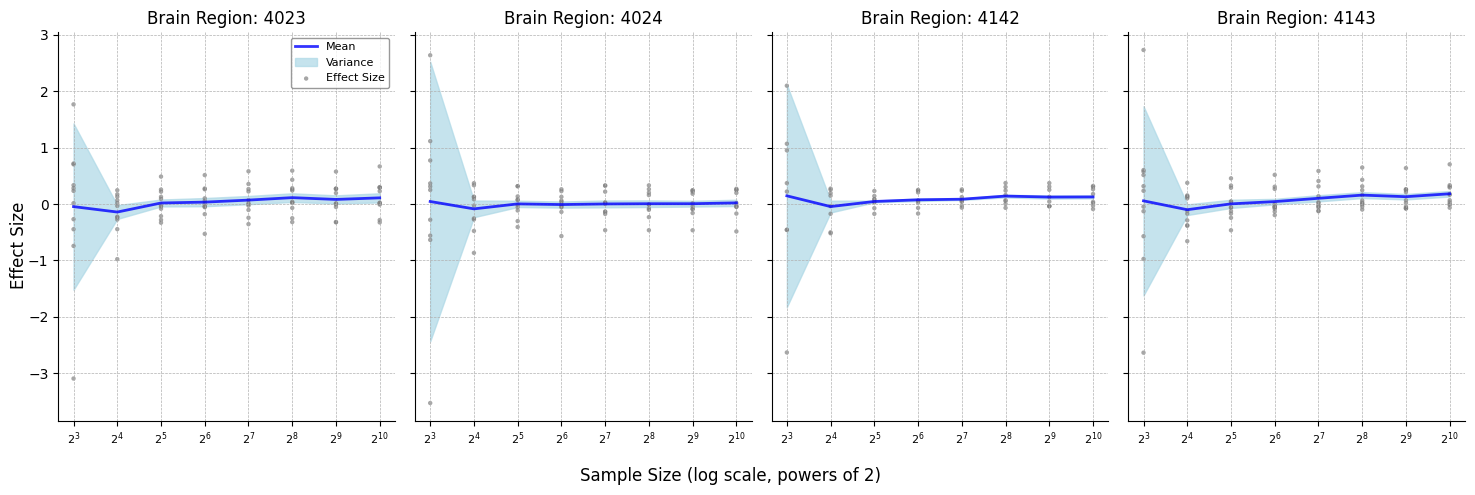

In [9]:
import numpy as np


# Define colors for means, variances, and effect sizes
mean_color = 'blue'  # Color for mean lines
variance_color = 'lightblue'  # Color for variance shading
effect_size_color = 'gray'  # Color for individual effect size points

# Define columns for effect sizes
columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
effect_size_df_mean = filtered_df_mean[columns]
effect_size_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_effect_size_mean = effect_size_df_mean.T.reset_index(drop=True)
transpose_effect_size_var = effect_size_df_var.T.reset_index(drop=True)

# Initialize figure with subplots
num_regions = len(transpose_effect_size_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 5), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_effect_size_mean)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[column].values - transpose_effect_size_var[column].values, 
                    transpose_effect_size_mean[column].values + transpose_effect_size_var[column].values, 
                    color=variance_color, alpha=0.7, label="Variance")
    
    # Plot individual effect size values
    # Filter rows where 'Value' is greater than 30 in each group
    region_samples = filtered_df.filter(lambda x: (x['brain_region']== column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=effect_size_color, alpha=0.7, s=10, edgecolor='none', label="Effect Size" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)  # Set logarithmic scale with base 2
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.set_title(f"Brain Region: {column}")
    
    # Add grid
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')


# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale, powers of 2)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("Effect Size", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("effect_size_vs_sample_size_1024.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Combined Facet of Pvalues of Different Brain Regions

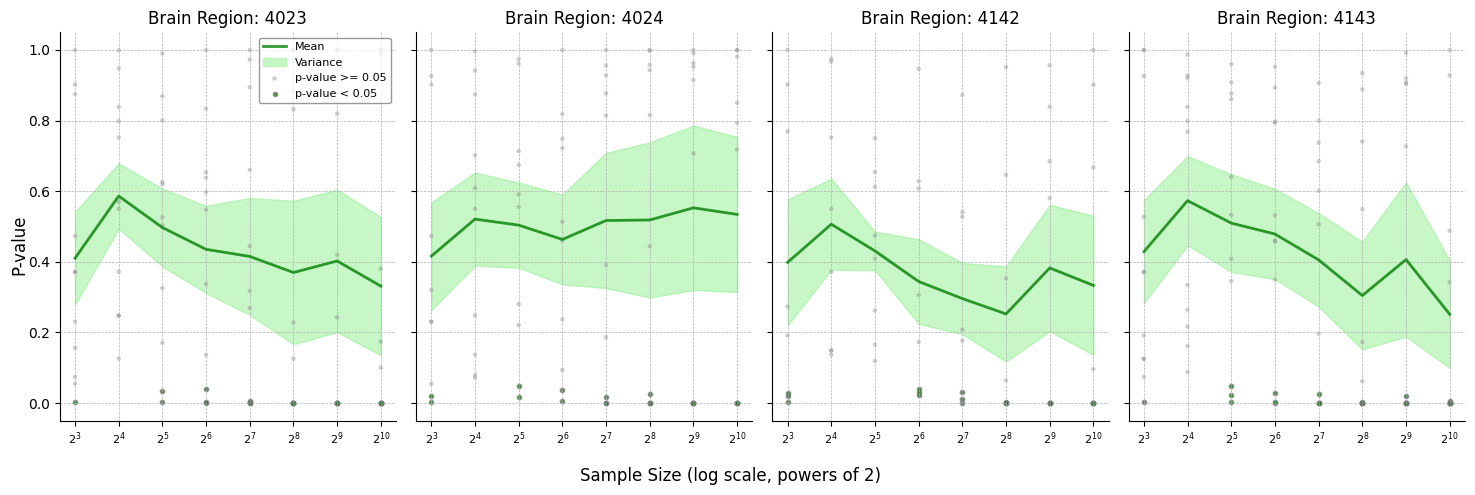

In [10]:
# Define colors for means, variances, and effect sizes
mean_color = 'green'  # Color for mean lines
variance_color = 'lightgreen'  # Color for variance shading
p_value_color = 'gray'  # New color for individual effect size points (close to green)
significant_color = 'darkgreen'  # Color for effect size points with p-value < 0.05

# Define columns for effect sizes
columns = [f"p-value_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
p_value_df_mean = filtered_df_mean[columns]
p_value_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_p_value_mean = p_value_df_mean.T.reset_index(drop=True)
transpose_p_value_var = p_value_df_var.T.reset_index(drop=True)

# Initialize figure with subplots
num_regions = len(transpose_p_value_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 5), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_p_value_mean)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_p_value_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_p_value_mean[column].values - transpose_p_value_var[column].values, 
                    transpose_p_value_mean[column].values + transpose_p_value_var[column].values, 
                    color=variance_color, alpha=0.5, label="Variance")
    
    # Plot individual effect size values
    # Filter rows where 'Value' is greater than 30 in each group
    region_samples = filtered_df.filter(lambda x: (x['brain_region']== column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"p-value_{sample_size}"]
        p_values = region_samples[f"p-value_{sample_size}"]
        
        # Plot points with p-value >= 0.05 in limegreen
        non_significant_mask = p_values >= 0.05
        ax.scatter([sample_size] * non_significant_mask.sum(), sample_values[non_significant_mask], 
                   color=p_value_color, alpha=0.4, s=10, edgecolor='none', label="p-value >= 0.05" if sample_idx == 0 else "")
        
        # Plot points with p-value < 0.05 in red
        significant_mask = p_values < 0.05
        ax.scatter([sample_size] * significant_mask.sum(), sample_values[significant_mask], 
                   color=significant_color, alpha=0.7, s=10, edgecolor='gray', label="p-value < 0.05" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)  # Set logarithmic scale with base 2
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
     
    ax.set_title(f"Brain Region: {column}")
    
    # Add grid
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')


# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale, powers of 2)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("P-value", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("p-value_vs_sample_size_1024.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Combined Facet of Power Values for Different Regions

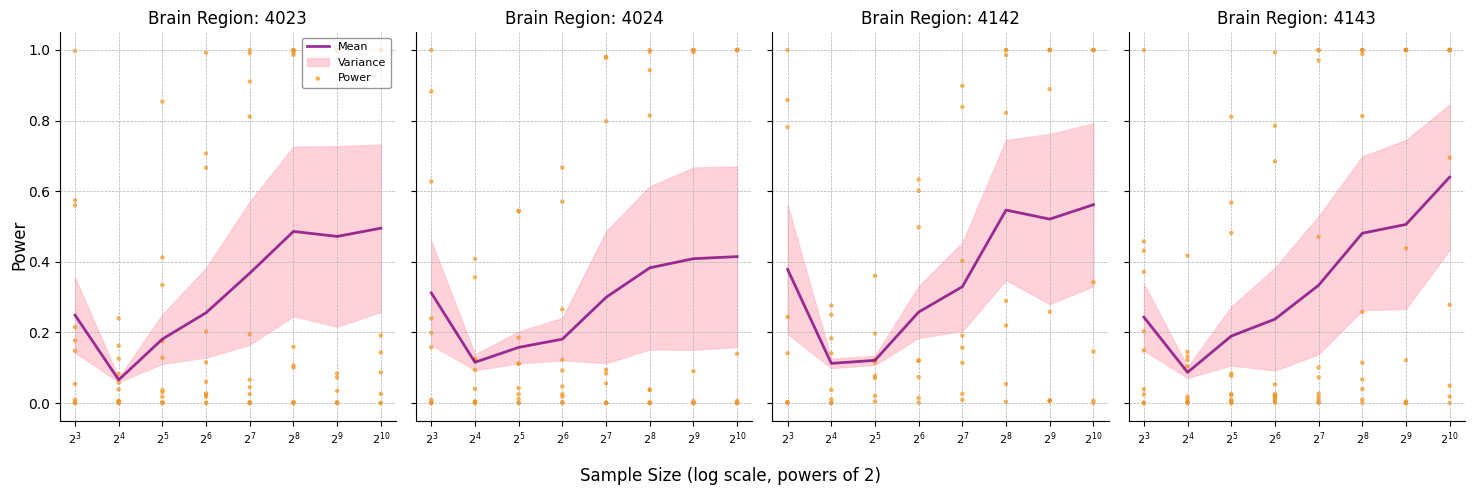

In [11]:
# Define colors for means, variances, and effect sizes
mean_color = 'purple'  # Color for mean lines
variance_color = 'pink'  # Color for variance shading
power_color = 'darkorange'  # Color for individual effect size points

# Define columns for effect sizes
columns = [f"power_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
power_df_mean = filtered_df_mean[columns]
power_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_power_mean = power_df_mean.T.reset_index(drop=True)
transpose_power_var = power_df_var.T.reset_index(drop=True)

# Initialize figure with subplots
num_regions = len(transpose_power_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 5), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_power_mean)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_power_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_power_mean[column].values - transpose_power_var[column].values, 
                    transpose_power_mean[column].values + transpose_power_var[column].values, 
                    color=variance_color, alpha=0.7, label="Variance")
    
    # Plot individual effect size values
    # Filter rows where 'Value' is greater than 30 in each group
    region_samples = filtered_df.filter(lambda x: (x['brain_region']== column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"power_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=power_color, alpha=0.7, s=10, edgecolor='none', label="Power" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)  # Set logarithmic scale with base 2
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.set_title(f"Brain Region: {column}")
    
    # Add grid
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')


# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale, powers of 2)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("Power", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("power_vs_sample_size_1024.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Combined Facet of Power, Pvalue and Effect Size 

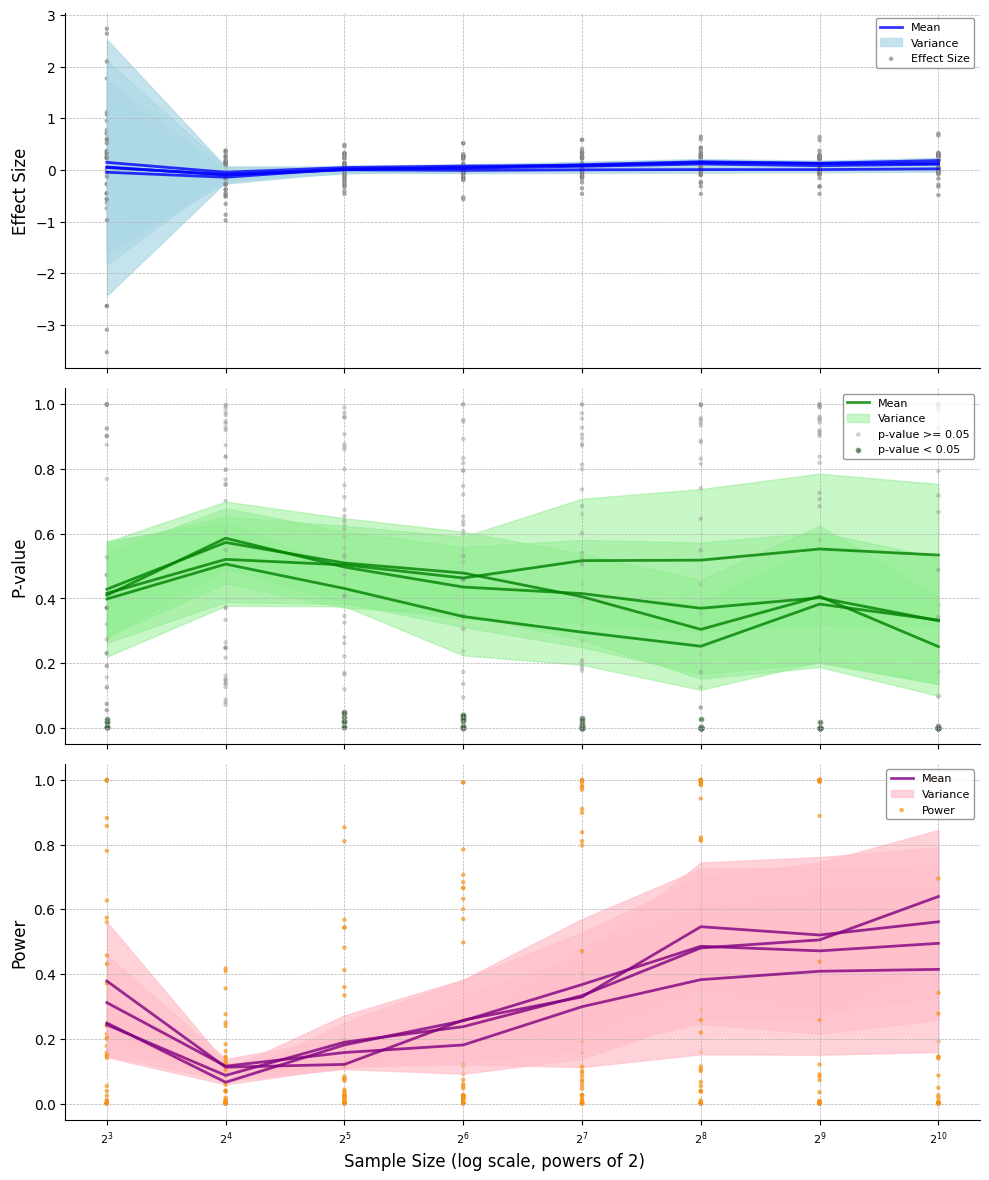

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the range of sample sizes as powers of 2
range_with_powers_of_two = [2**i for i in range(3, 11)]  # 2^3=8 to 2^10=1024

# Initialize figure with subplots (3 rows, 1 column)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Remove horizontal space between subplots
plt.subplots_adjust(hspace=0.1)

# Plot 1: Effect Size
# Define colors for effect size plot
mean_color = 'blue'
variance_color = 'lightblue'
effect_size_color = 'gray'

# Define columns for effect sizes
columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
effect_size_df_mean = filtered_df_mean[columns]
effect_size_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_effect_size_mean = effect_size_df_mean.T.reset_index(drop=True)
transpose_effect_size_var = effect_size_df_var.T.reset_index(drop=True)

# Plot each region in the first subplot
for idx, column in enumerate(transpose_effect_size_mean):
    ax = axes[0]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[column].values - transpose_effect_size_var[column].values, 
                    transpose_effect_size_mean[column].values + transpose_effect_size_var[column].values, 
                    color=variance_color, alpha=0.7, label="Variance")
    
    # Plot individual effect size values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=effect_size_color, alpha=0.7, s=10, edgecolor='none', label="Effect Size" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.set_ylabel("Effect Size", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')

# Plot 2: P-value
# Define colors for p-value plot
mean_color = 'green'
variance_color = 'lightgreen'
p_value_color = 'gray'
significant_color = 'darkgreen'

# Define columns for p-values
columns = [f"p-value_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
p_value_df_mean = filtered_df_mean[columns]
p_value_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_p_value_mean = p_value_df_mean.T.reset_index(drop=True)
transpose_p_value_var = p_value_df_var.T.reset_index(drop=True)

# Plot each region in the second subplot
for idx, column in enumerate(transpose_p_value_mean):
    ax = axes[1]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_p_value_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_p_value_mean[column].values - transpose_p_value_var[column].values, 
                    transpose_p_value_mean[column].values + transpose_p_value_var[column].values, 
                    color=variance_color, alpha=0.5, label="Variance")
    
    # Plot individual p-values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"p-value_{sample_size}"]
        p_values = region_samples[f"p-value_{sample_size}"]
        
        # Plot points with p-value >= 0.05
        non_significant_mask = p_values >= 0.05
        ax.scatter([sample_size] * non_significant_mask.sum(), sample_values[non_significant_mask], 
                   color=p_value_color, alpha=0.4, s=10, edgecolor='none', label="p-value >= 0.05" if sample_idx == 0 else "")
        
        # Plot points with p-value < 0.05
        significant_mask = p_values < 0.05
        ax.scatter([sample_size] * significant_mask.sum(), sample_values[significant_mask], 
                   color=significant_color, alpha=0.7, s=10, edgecolor='gray', label="p-value < 0.05" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.set_ylabel("P-value", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')

# Plot 3: Power
# Define colors for power plot
mean_color = 'purple'
variance_color = 'pink'
power_color = 'darkorange'

# Define columns for power
columns = [f"power_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
power_df_mean = filtered_df_mean[columns]
power_df_var = filtered_df_var[columns]

# Transpose for plotting
transpose_power_mean = power_df_mean.T.reset_index(drop=True)
transpose_power_var = power_df_var.T.reset_index(drop=True)

# Plot each region in the third subplot
for idx, column in enumerate(transpose_power_mean):
    ax = axes[2]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_power_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_power_mean[column].values - transpose_power_var[column].values, 
                    transpose_power_mean[column].values + transpose_power_var[column].values, 
                    color=variance_color, alpha=0.7, label="Variance")
    
    # Plot individual power values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == column).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"power_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=power_color, alpha=0.7, s=10, edgecolor='none', label="Power" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.set_ylabel("Power", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')

# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale, powers of 2)", fontsize=12, y=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("combined_plot.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

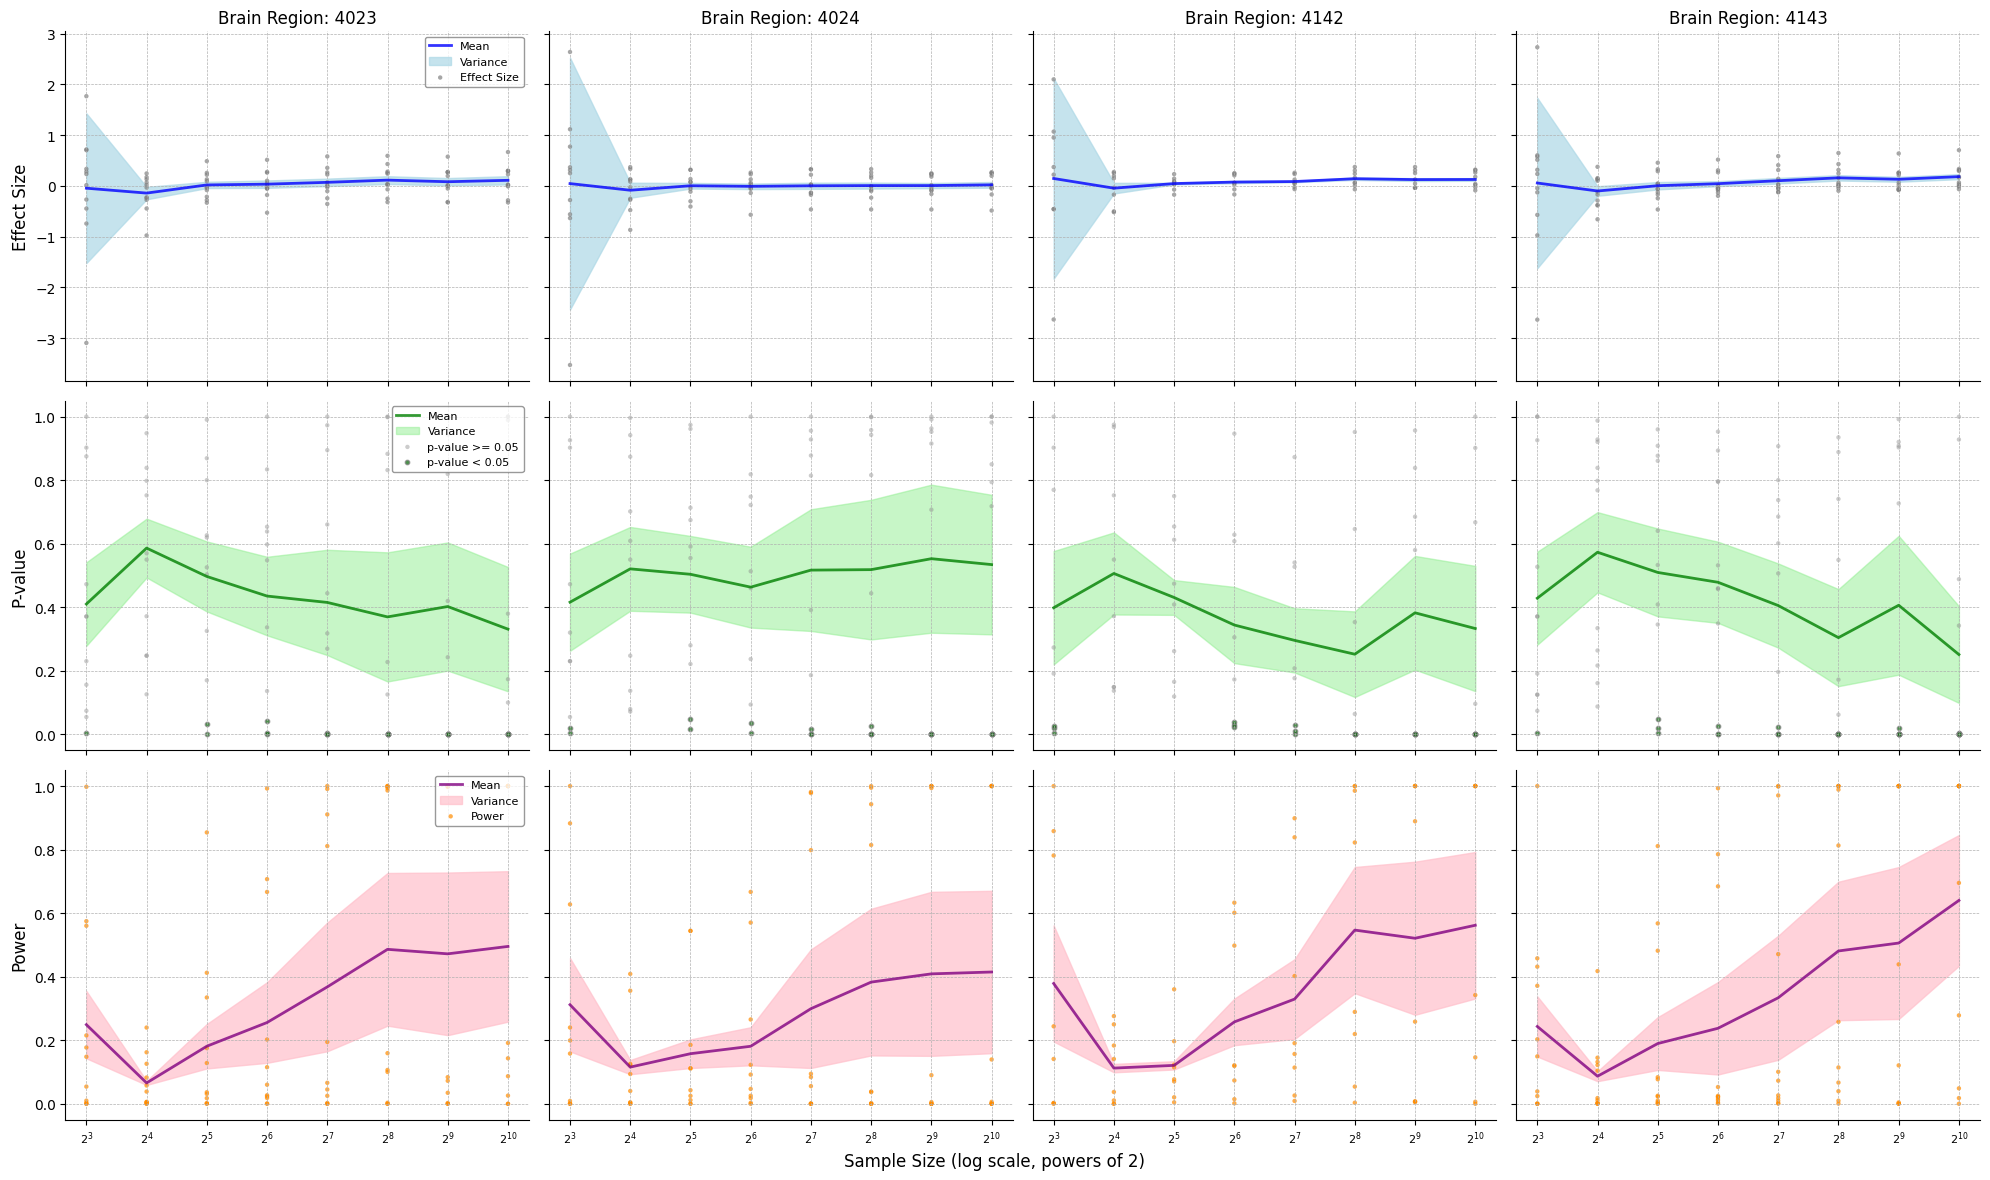

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the range of sample sizes as powers of 2
range_with_powers_of_two = [2**i for i in range(3, 11)]  # 2^3=8 to 2^10=1024

# Define brain regions (assuming you have 4 regions)
brain_regions = transpose_effect_size_mean.columns  # Replace with your actual brain region names

# Initialize figure with subplots (3 rows for metrics, 4 columns for brain regions)
fig, axes = plt.subplots(nrows=3, ncols=len(brain_regions), figsize=(20, 12), sharex=True, sharey='row')

# Remove horizontal space between subplots
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Define colors for each metric
effect_size_colors = {'mean': 'blue', 'variance': 'lightblue', 'points': 'gray'}
p_value_colors = {'mean': 'green', 'variance': 'lightgreen', 'non_significant': 'gray', 'significant': 'darkgreen'}
power_colors = {'mean': 'purple', 'variance': 'pink', 'points': 'darkorange'}

# Loop through each brain region (columns)
for col_idx, region in enumerate(brain_regions):
    # Plot 1: Effect Size
    ax = axes[0, col_idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[region].values, 
            color=effect_size_colors['mean'], linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[region].values - transpose_effect_size_var[region].values, 
                    transpose_effect_size_mean[region].values + transpose_effect_size_var[region].values, 
                    color=effect_size_colors['variance'], alpha=0.7, label="Variance")
    
    # Plot individual effect size values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == region).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=effect_size_colors['points'], alpha=0.7, s=10, edgecolor='none', label="Effect Size" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
   
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if col_idx == 0:
        ax.set_ylabel("Effect Size", fontsize=12)
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')
    
    # Set title for the column (brain region)
    ax.set_title(f"Brain Region: {region}", fontsize=12)

    # Plot 2: P-value
    ax = axes[1, col_idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_p_value_mean[region].values, 
            color=p_value_colors['mean'], linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_p_value_mean[region].values - transpose_p_value_var[region].values, 
                    transpose_p_value_mean[region].values + transpose_p_value_var[region].values, 
                    color=p_value_colors['variance'], alpha=0.5, label="Variance")
    
    # Plot individual p-values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == region).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"p-value_{sample_size}"]
        p_values = region_samples[f"p-value_{sample_size}"]
        
        # Plot points with p-value >= 0.05
        non_significant_mask = p_values >= 0.05
        ax.scatter([sample_size] * non_significant_mask.sum(), sample_values[non_significant_mask], 
                   color=p_value_colors['non_significant'], alpha=0.4, s=10, edgecolor='none', label="p-value >= 0.05" if sample_idx == 0 else "")
        
        # Plot points with p-value < 0.05
        significant_mask = p_values < 0.05
        ax.scatter([sample_size] * significant_mask.sum(), sample_values[significant_mask], 
                   color=p_value_colors['significant'], alpha=0.7, s=10, edgecolor='gray', label="p-value < 0.05" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)

    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if col_idx == 0:
        ax.set_ylabel("P-value", fontsize=12)
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')

    # Plot 3: Power
    ax = axes[2, col_idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_power_mean[region].values, 
            color=power_colors['mean'], linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_power_mean[region].values - transpose_power_var[region].values, 
                    transpose_power_mean[region].values + transpose_power_var[region].values, 
                    color=power_colors['variance'], alpha=0.7, label="Variance")
    
    # Plot individual power values
    region_samples = filtered_df.filter(lambda x: (x['brain_region'] == region).any())
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"power_{sample_size}"]
        ax.scatter([sample_size] * len(sample_values), sample_values, 
                   color=power_colors['points'], alpha=0.7, s=10, edgecolor='none', label="Power" if sample_idx == 0 else "")
    
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if col_idx == 0:
        ax.set_ylabel("Power", fontsize=12)
        ax.legend(loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')

# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size (log scale, powers of 2)", fontsize=12, y=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("combined_plot_with_regions.png")  # You can change the file name and format (e.g., .pdf, .svg)
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Power VS P-Value with Color Coded Effect Size

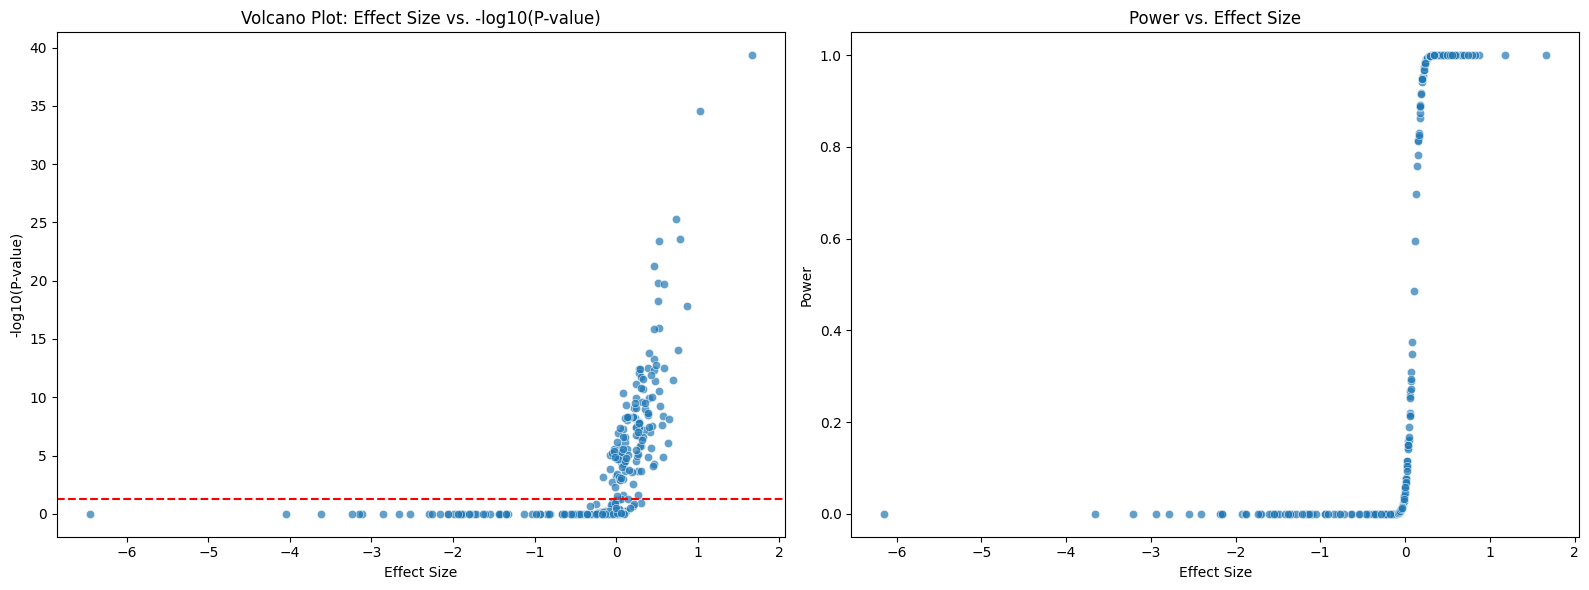

In [50]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Volcano Plot
stats_df["log_pvalue"] = -np.log10(stats_df["p-value_256"])
sns.scatterplot(x="effect_size_64", y="log_pvalue", data=stats_df, alpha=0.7, ax=axes[0])
axes[0].axhline(-np.log10(0.05), color="red", linestyle="--")  # Significance threshold
axes[0].set_title("Volcano Plot: Effect Size vs. -log10(P-value)")
axes[0].set_xlabel("Effect Size")
axes[0].set_ylabel("-log10(P-value)")

# Power vs. Effect Size Plot
sns.scatterplot(x="effect_size_256", y="power_256", data=stats_df, alpha=0.7, ax=axes[1])
axes[1].set_title("Power vs. Effect Size")
axes[1].set_xlabel("Effect Size")
axes[1].set_ylabel("Power")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [52]:
stats_df.head(3)

,brain_region,gene_id,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,t_stat_16,...,effect_size_512,p-value_512,power_512,t_stat_512,effect_size_1024,p-value_1024,power_1024,t_stat_1024,log_pvalue,log_effect_size
0,4012,2541,0.723958,0.039062,0.579479,31.0,0.170152,0.231873,0.159962,83.0,...,0.179155,8.732317e-07,0.991882,81676.0,0.285270,1.100408e-22,1.000000,354526.0,4.886501,-1.403086
1,4013,1259,0.576161,0.125000,0.431013,27.0,-0.327191,0.798126,0.001882,52.0,...,0.152272,4.490161e-06,0.963761,80536.0,0.088223,1.216660e-05,0.880289,302356.0,5.745714,-1.373789
2,4013,2541,0.716566,0.054688,0.572157,30.0,0.205089,0.247711,0.194567,82.0,...,0.324791,3.459548e-14,1.000000,90748.0,0.264883,9.052327e-20,1.000000,347825.0,7.267138,-1.090282


### Combined Plot of Power, Pvalue and Effect Size

In [18]:
stats_df = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))

range_with_powers_of_two = [2**i for i in range(3, 11)] 

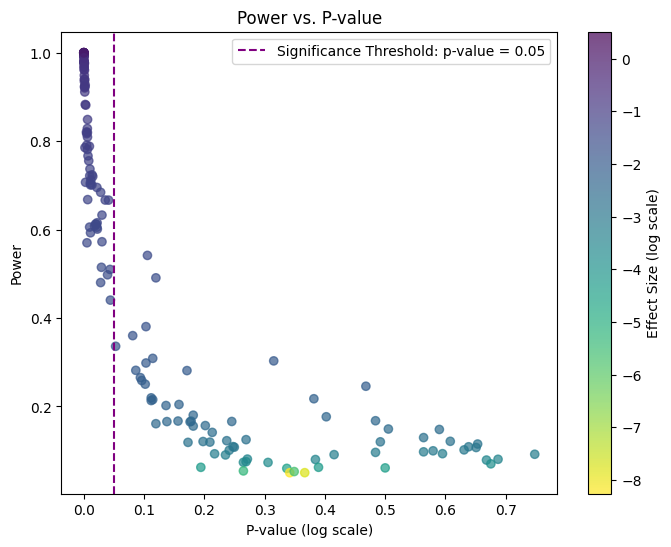

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Apply log transformation to the effect size (optional)
stats_df["log_effect_size"] = np.log(stats_df["effect_size_64"] + 1e-6)

# Create a colormap and normalize it
cmap = cm.viridis_r  # Choose a color map
norm = mcolors.Normalize(vmin=stats_df["log_effect_size"].min(), vmax=stats_df["log_effect_size"].max())

# Create the figure and scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    stats_df["p-value_64"], stats_df["power_64"], 
    c=stats_df["log_effect_size"], cmap=cmap, alpha=0.7
)

# Add the significance threshold line
ax.axvline(0.05, color="purple", linestyle="--", label="Significance Threshold: p-value = 0.05")

# Create a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Effect Size (log scale)")

# Labels and title
plt.title("Power vs. P-value")
plt.xlabel("P-value (log scale)")
plt.ylabel("Power")
plt.legend()

plt.savefig(PLOTS_PTH / Path('PL_06_7_Power_P-Value_Effect_Size_64.png'))
plt.show()


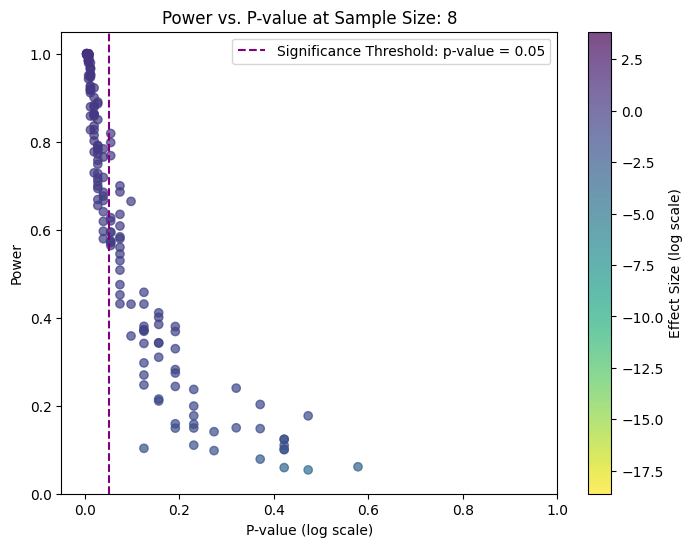

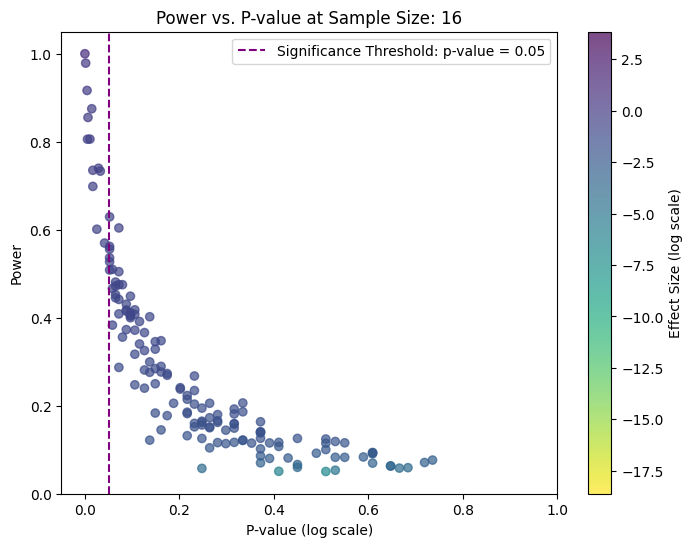

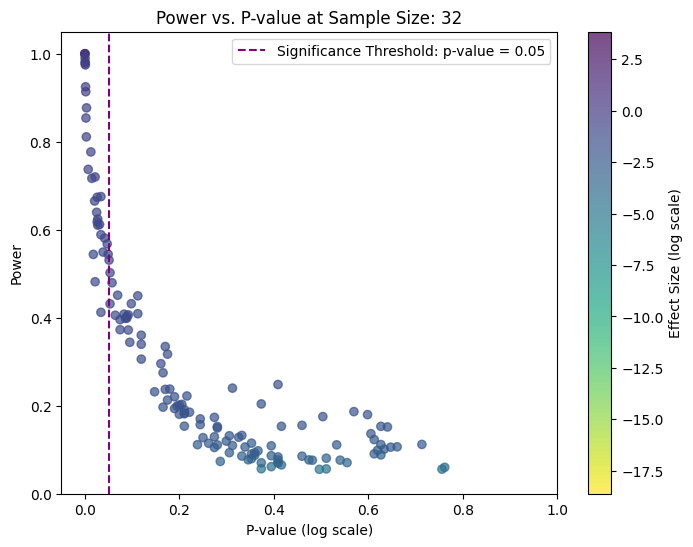

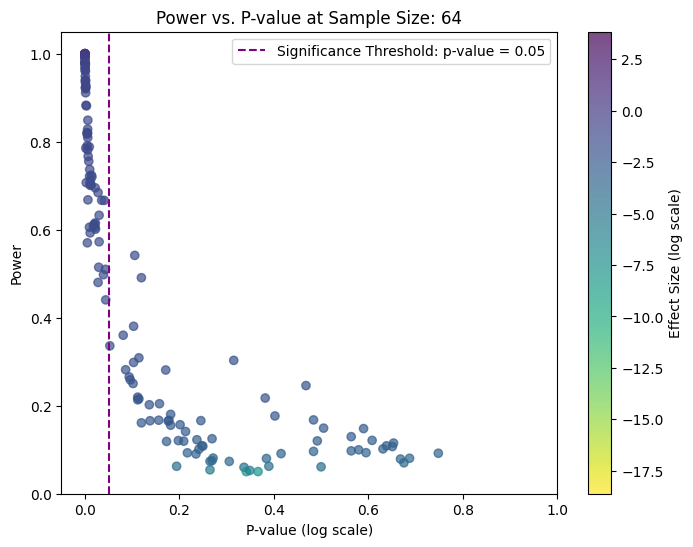

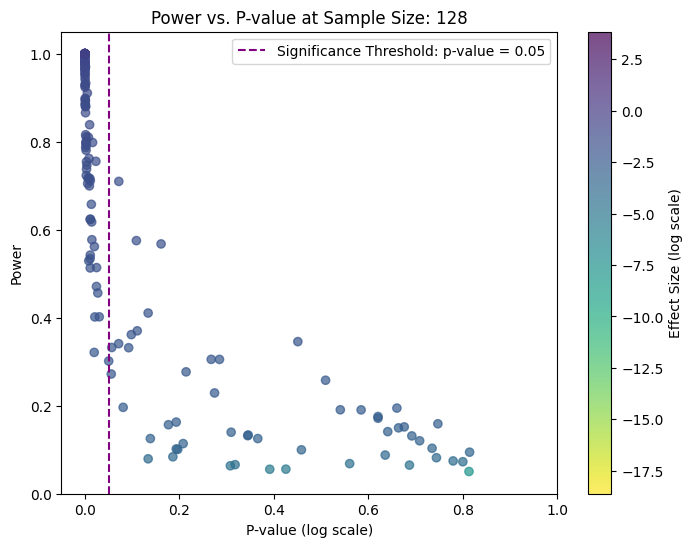

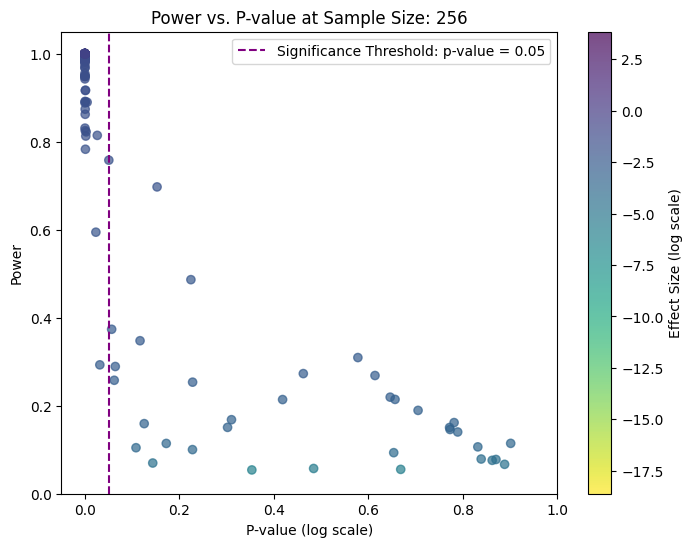

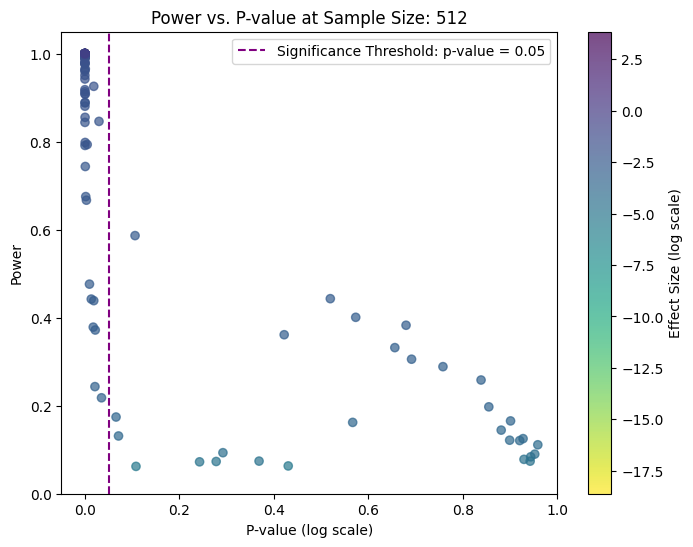

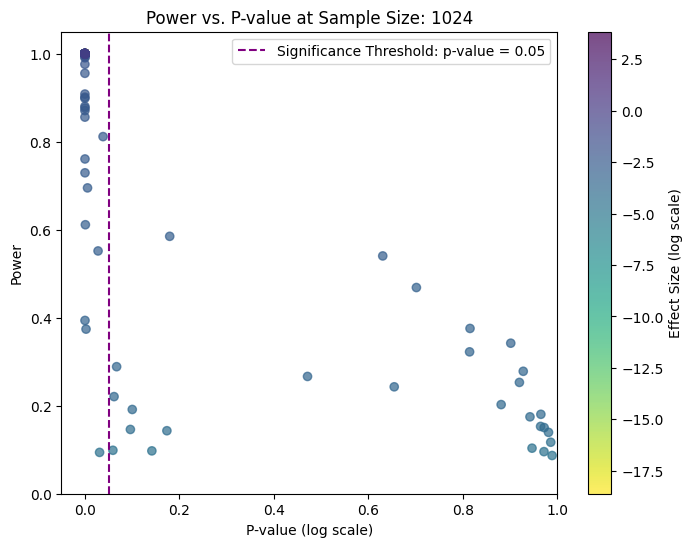

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

for sample_size in range_with_powers_of_two:

    # Apply log transformation to the effect size (optional)
    stats_df[f"log_effect_size_{sample_size}"] = np.log(stats_df[f"effect_size_{sample_size}"] + 1e-6)

sample_size = 1024
# Calculate global min and max for effect sizes across all sample sizes
global_min = np.min([np.min(stats_df[f"effect_size_{sample_size}"]) for sample_size in range_with_powers_of_two])
global_max = np.max([np.max(stats_df[f"effect_size_{sample_size}"]) for sample_size in range_with_powers_of_two])

# Calculate global min and max for p-values across all sample sizes
global_x_min = np.min([np.min(stats_df[f"p-value_{sample_size}"]) for sample_size in range_with_powers_of_two])
global_x_max = np.max([np.max(stats_df[f"p-value_{sample_size}"]) for sample_size in range_with_powers_of_two])

# Calculate global min and max for p-values across all sample sizes
global_y_min = np.min([np.min(stats_df[f"power_{sample_size}"]) for sample_size in range_with_powers_of_two])
global_y_max = np.max([np.max(stats_df[f"power_{sample_size}"]) for sample_size in range_with_powers_of_two])



# Create a colormap and normalization based on the global range
cmap = cm.viridis_r  # Choose a color map
norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

# Loop to create each plot for the sample sizes
for sample_size in range_with_powers_of_two:

    # Create the figure and scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        stats_df[f"p-value_{sample_size}"], stats_df[f"power_{sample_size}"], 
        c=stats_df[f"log_effect_size_{sample_size}"], cmap=cmap, norm=norm, alpha=0.7
    )

    # Add the significance threshold line
    ax.axvline(0.05, color="purple", linestyle="--", label="Significance Threshold: p-value = 0.05")
    # Set the x-axis limits to the global p-value range
    ax.set_xlim(global_x_min-0.05, global_x_max)
    
    ax.set_ylim(global_y_min, global_y_max+0.05)


    # Create a colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Effect Size (log scale)")

    # Labels and title
    plt.title(f"Power vs. P-value at Sample Size: {sample_size}")
    plt.xlabel("P-value (log scale)")
    plt.ylabel("Power")
    plt.legend()
    
    plt.savefig(f"plot_sample_size_{sample_size}.png")


    # Show the plot
    plt.show()
    plt.close()

Saving GIF Image

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import imageio
import os 

# List all the plot images
image_files = [f"plot_sample_size_{size}.png" for size in range_with_powers_of_two]

# Create GIF
with imageio.get_writer(PLOTS_PTH / Path('PL_06_8_Power_P-Value_Effect_Size_Animation.gif'), mode='I', duration=1) as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

# Optionally, remove the image files after creating the GIF
for image_file in image_files:
    os.remove(image_file)

/tmp/ipykernel_2599939/383953801.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)
